# Import Statements

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

In [3]:
data = pd.read_csv("D:\\FYP\\AzureDatasetPacking2019\\Aggregated Data\\aggregated_vmtable_correct_dates.csv")

In [4]:
data["index"] = pd.to_datetime(data["index"])
data = data.set_index("index")
data = data[["vm_memory_gb"]]
data.drop(data.tail(1).index,inplace=True)

In [5]:
data.tail()

,vm_memory_gb
index,
2016-12-15 23:30:00,339591.25
2016-12-15 23:35:00,337958.75
2016-12-15 23:40:00,337061.75
2016-12-15 23:45:00,336097.00
2016-12-15 23:50:00,334848.25


# detrend the data

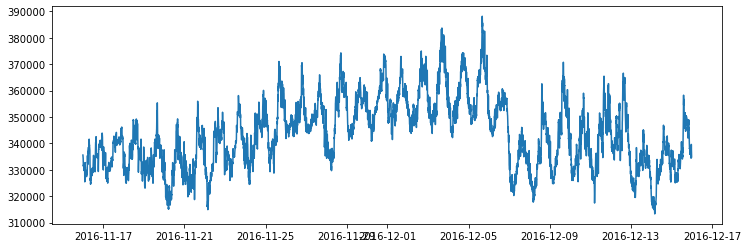

In [6]:
plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

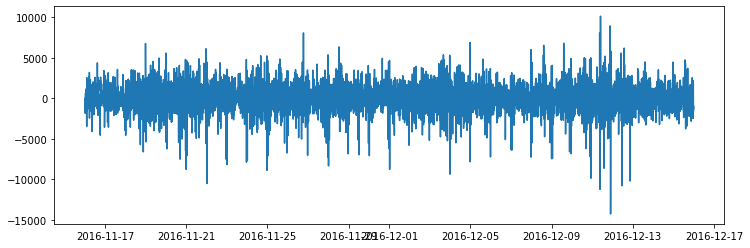

In [7]:
data = data.diff()
data = data.drop(data.head(1).index)

plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

# Rolling Window DataFrame
## Window: 48 (4 hours)
VM Table Memory

In [8]:
col_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14",
              "x15", "x16", "x17", "x18", "x19", "x20", "x21", "x22", "x23", "x24", "x25", "x26", "x27",
              "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40",
              "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [9]:
windows = 48

rw48_predictions = data.reset_index()

rw48_windows = pd.DataFrame([window.to_list() for window in data["vm_memory_gb"].rolling(window=windows+1)], 
                          columns =  col_names + ["extra"])

rw48_predictions = pd.merge(rw48_predictions, rw48_windows, left_index=True, right_index=True)
           
rw48_predictions.head()

,index,vm_memory_gb,x1,x2,x3,x4,x5,x6,x7,x8,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,extra
0,2016-11-16 00:05:00,-162.75,-162.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-11-16 00:10:00,-513.00,-162.75,-513.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-11-16 00:15:00,-245.50,-162.75,-513.0,-245.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-11-16 00:20:00,-325.75,-162.75,-513.0,-245.5,-325.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-11-16 00:25:00,-1831.00,-162.75,-513.0,-245.5,-325.75,-1831.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
rw48_predictions = rw48_predictions.drop(rw48_predictions.head(windows+1).index) # drop first rows with NAN values

In [11]:
rw48_predictions = rw48_predictions[["index", "vm_memory_gb"] + col_names]

In [12]:
train, test = train_test_split(rw48_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 50), (1718, 50))

# Normalise the data

In [13]:
scaler = MinMaxScaler()
train[["vm_memory_gb"] + col_names] = scaler.fit_transform(train[["vm_memory_gb"] + col_names])
test[["vm_memory_gb"] + col_names] = scaler.transform(test[["vm_memory_gb"] + col_names])

In [13]:
norm_memory_cpu = pd.concat([train, test])
norm_memory_cpu.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Normalised Data/memory_norm.csv")

In [14]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['vm_memory_gb'].values, test_size=0.2, random_state=42, shuffle=False)

In [15]:
x_train = train[col_names]
y_train = train["vm_memory_gb"]
x_test = test[col_names]
y_test = test["vm_memory_gb"]

# Prediction Models
Two Step ahead prediction
### Baseline

In [16]:
test["baseline"] = test[["vm_memory_gb"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor

### Linear Model

In [17]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.06241990562530031


In [18]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

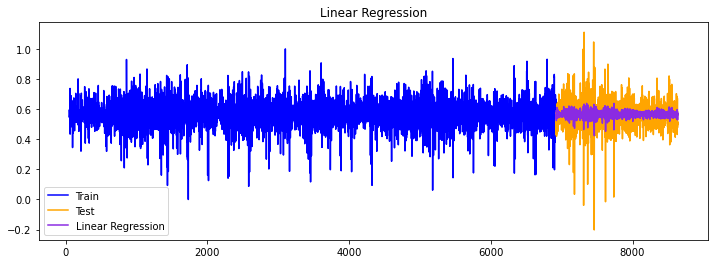

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [20]:
rw48_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["vm_memory_gb"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['vm_memory_gb'], test['baseline']))] })

In [21]:
lr_mape = mean_absolute_error(test["vm_memory_gb"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw48_results = pd.concat([rw48_results, lr_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059328,0.085116


### Decision Tree

In [22]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 3}
0.03771421696838545


In [28]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

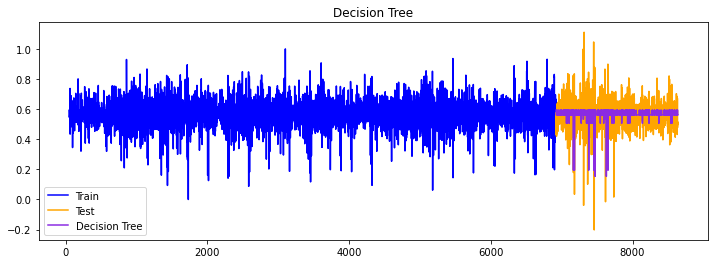

In [29]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [30]:
dt_mape = mean_absolute_error(test["vm_memory_gb"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw48_results = pd.concat([rw48_results, dt_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059328,0.085116
0,Decision Tree,0.059583,0.086302


### Random Forest

In [23]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.08532178920707656


In [31]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

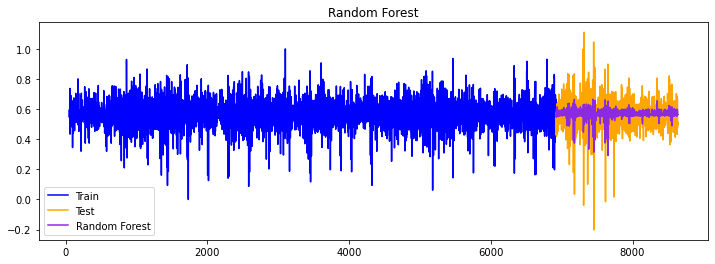

In [32]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [33]:
rf_mape = mean_absolute_error(test["vm_memory_gb"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw48_results = pd.concat([rw48_results, rf_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059328,0.085116
0,Decision Tree,0.059583,0.086302
0,Random Forest,0.058993,0.084309


### Gradient Boosting

In [24]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}
0.08170549588197051


In [34]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=100, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

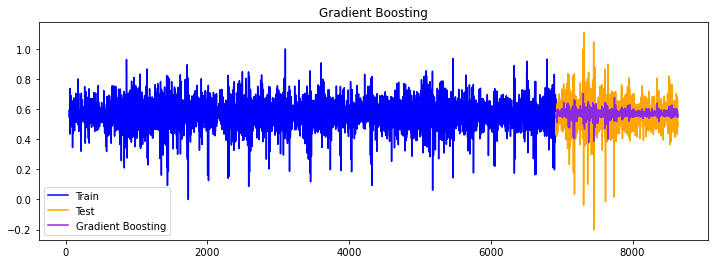

In [35]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [36]:
gb_mape = mean_absolute_error(test["vm_memory_gb"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw48_results = pd.concat([rw48_results, gb_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059328,0.085116
0,Decision Tree,0.059583,0.086302
0,Random Forest,0.058993,0.084309
0,Gradient Boosting,0.059079,0.084269


### KNN

In [25]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
-0.007702276051166357


In [37]:
knn_model = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

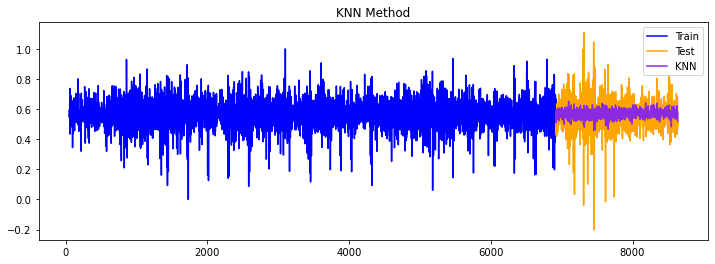

In [38]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [39]:
knn_mape = mean_absolute_error(test["vm_memory_gb"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw48_results = pd.concat([rw48_results, knn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059328,0.085116
0,Decision Tree,0.059583,0.086302
0,Random Forest,0.058993,0.084309
0,Gradient Boosting,0.059079,0.084269
0,KNN,0.061859,0.088270


### Neural Network

In [26]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'tanh', 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.06825041903801654


In [40]:
nn_model = MLPRegressor(random_state=1, activation='tanh', hidden_layer_sizes=150, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

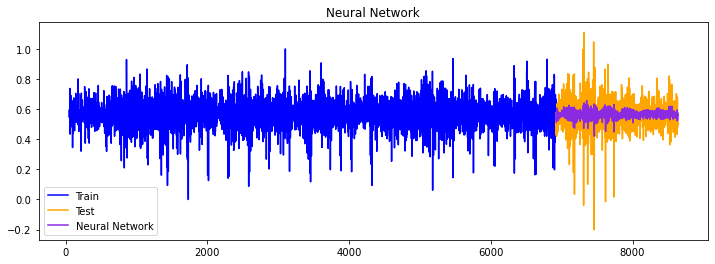

In [41]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [42]:
nn_mape = mean_absolute_error(test["vm_memory_gb"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw48_results = pd.concat([rw48_results, nn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059328,0.085116
0,Decision Tree,0.059583,0.086302
0,Random Forest,0.058993,0.084309
0,Gradient Boosting,0.059079,0.084269
0,KNN,0.061859,0.088270
0,Neural Network,0.059602,0.085413


### Simple Moving Average

In [27]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:] +[0]

In [43]:
test = test.drop(test.head(1).index) # Drop last row

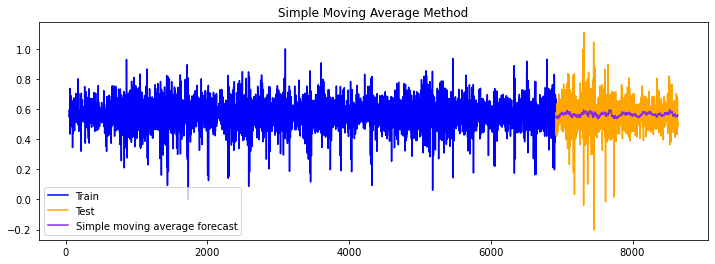

In [44]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [45]:
sma_mape = mean_absolute_error(test["vm_memory_gb"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw48_results = pd.concat([rw48_results, sma_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059328,0.085116
0,Decision Tree,0.059583,0.086302
0,Random Forest,0.058993,0.084309
0,Gradient Boosting,0.059079,0.084269
0,KNN,0.061859,0.088270
0,Neural Network,0.059602,0.085413
0,Simple Moving Avg.,0.060773,0.087852


## Window: 24 (2 hours)
VM Table Memory

In [46]:
window = 24

rw24_predictions = rw48_predictions[["index", "vm_memory_gb", "x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32",
                                    "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw24_predictions.head()

,index,vm_memory_gb,x25,x26,x27,x28,x29,x30,x31,x32,...,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,-297.50,-2374.00,-3448.75,2555.25,2065.25,1995.25,689.00,-1563.25,-105.25,...,975.25,142.75,-603.50,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.5
50,2016-11-16 04:15:00,-226.50,-3448.75,2555.25,2065.25,1995.25,689.00,-1563.25,-105.25,-180.75,...,142.75,-603.50,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.50,-297.5
51,2016-11-16 04:20:00,-184.50,2555.25,2065.25,1995.25,689.00,-1563.25,-105.25,-180.75,273.50,...,-603.50,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.50,-297.50,-226.5
52,2016-11-16 04:25:00,13.00,2065.25,1995.25,689.00,-1563.25,-105.25,-180.75,273.50,-584.50,...,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.50,-297.50,-226.50,-184.5
53,2016-11-16 04:30:00,353.75,1995.25,689.00,-1563.25,-105.25,-180.75,273.50,-584.50,-209.50,...,-523.50,147.75,175.75,-250.50,-479.75,-182.50,-297.50,-226.50,-184.50,13.0


In [47]:
train, test = train_test_split(rw24_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 26), (1718, 26))

# Normalise the data

In [48]:
col_names = ["x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40","x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [49]:
scaler = MinMaxScaler()
train[["vm_memory_gb"] + col_names] = scaler.fit_transform(train[["vm_memory_gb"] + col_names])
test[["vm_memory_gb"] + col_names] = scaler.transform(test[["vm_memory_gb"] + col_names])

In [50]:
x_train, x_test, y_train, y_test = train_test_split(rw24_predictions[col_names].values, rw24_predictions['vm_memory_gb'].values, test_size=0.2, random_state=42, shuffle=False)

In [51]:
x_train = train[col_names]
y_train = train["vm_memory_gb"]
x_test = test[col_names]
y_test = test["vm_memory_gb"]

# Prediction Models
Two Step ahead prediction
### Baseline

In [52]:
test["baseline"] = test[["vm_memory_gb"]].shift(1)
test = test.drop(test.head(1).index)

### Linear Regression

In [53]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.057267425604373035


In [54]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

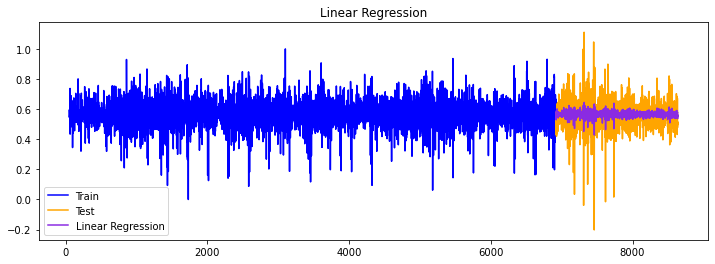

In [55]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [56]:
rw24_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["vm_memory_gb"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['vm_memory_gb'], test['baseline']))] })

In [57]:
lr_mape = mean_absolute_error(test["vm_memory_gb"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw24_results = pd.concat([rw24_results, lr_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059372,0.085086


### Decision Tree

In [58]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 3}
0.03771421696838512


In [64]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

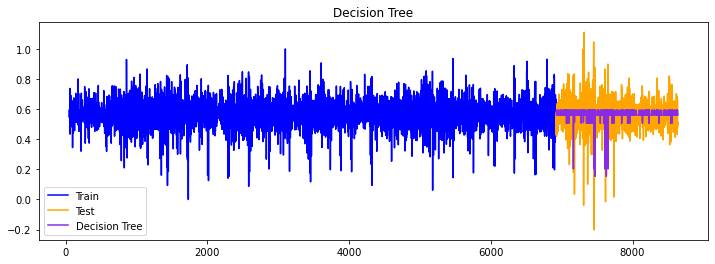

In [65]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [66]:
dt_mape = mean_absolute_error(test["vm_memory_gb"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw24_results = pd.concat([rw24_results, dt_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059372,0.085086
0,Decision Tree,0.059644,0.086634


### Random Forest

In [59]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.08743763121614923


In [67]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

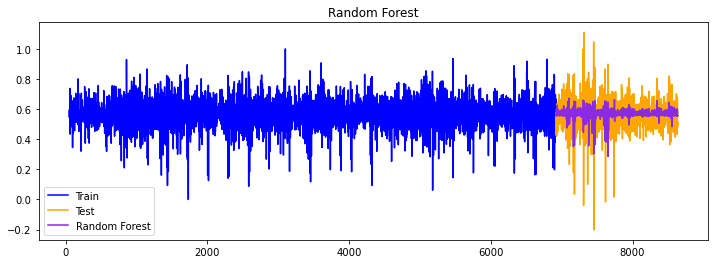

In [68]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [69]:
rf_mape = mean_absolute_error(test["vm_memory_gb"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw24_results = pd.concat([rw24_results, rf_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059372,0.085086
0,Decision Tree,0.059644,0.086634
0,Random Forest,0.059270,0.084498


### Gradient Boosting

In [60]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 5, 'n_estimators': 100}
0.08004722988125118


In [70]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=5, n_estimators=100 ,random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

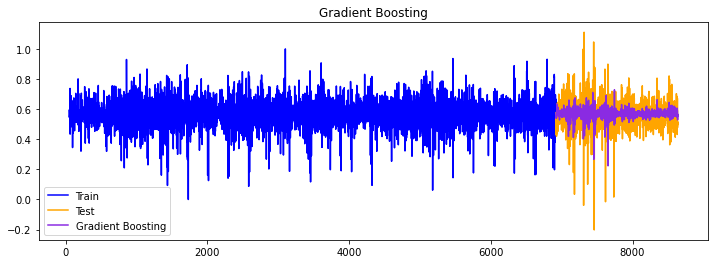

In [71]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [72]:
gb_mape = mean_absolute_error(test["vm_memory_gb"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw24_results = pd.concat([rw24_results, gb_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059372,0.085086
0,Decision Tree,0.059644,0.086634
0,Random Forest,0.059270,0.084498
0,Gradient Boosting,0.060181,0.085258


### KNN

In [61]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
0.014571384163548584


In [73]:
knn_model = KNeighborsRegressor(algorithm='auto', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

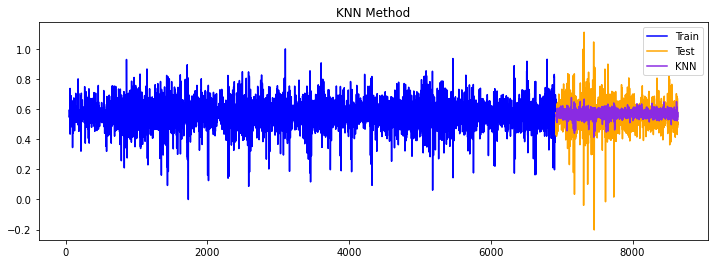

In [74]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [75]:
knn_mape = mean_absolute_error(test["vm_memory_gb"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw24_results = pd.concat([rw24_results, knn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059372,0.085086
0,Decision Tree,0.059644,0.086634
0,Random Forest,0.059270,0.084498
0,Gradient Boosting,0.060181,0.085258
0,KNN,0.061483,0.086978


### Neural Network

In [62]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'relu', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.0639184309942572


In [76]:
nn_model = MLPRegressor(random_state=1, activation='relu', hidden_layer_sizes=100, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

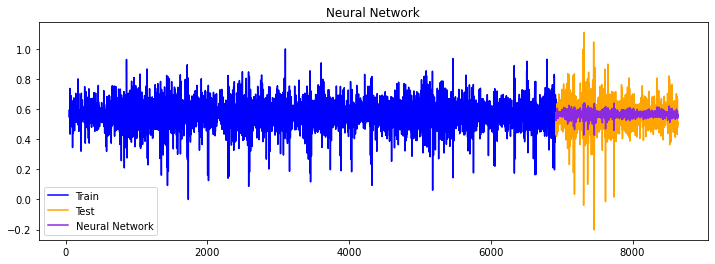

In [77]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [78]:
nn_mape = mean_absolute_error(test["vm_memory_gb"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw24_results = pd.concat([rw24_results, nn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059372,0.085086
0,Decision Tree,0.059644,0.086634
0,Random Forest,0.059270,0.084498
0,Gradient Boosting,0.060181,0.085258
0,KNN,0.061483,0.086978
0,Neural Network,0.059513,0.085128


### Simple Moving Average

In [63]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:]+[0]

In [79]:
test = test.drop(test.head(1).index) # Drop last row

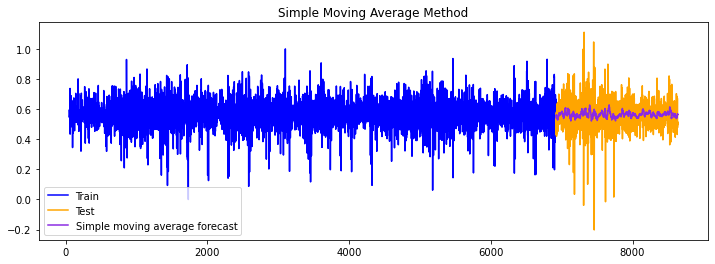

In [80]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [81]:
sma_mape = mean_absolute_error(test["vm_memory_gb"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw24_results = pd.concat([rw24_results, sma_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059372,0.085086
0,Decision Tree,0.059644,0.086634
0,Random Forest,0.059270,0.084498
0,Gradient Boosting,0.060181,0.085258
0,KNN,0.061483,0.086978
0,Neural Network,0.059513,0.085128
0,Simple Moving Avg.,0.061331,0.088798


## Window: 12 (60 minutes)
VM Table Memory

In [13]:
col_names = ["x37", "x38", "x39", "x40", "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [14]:
window = 12

rw12_predictions = rw48_predictions[["index", "vm_memory_gb", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw12_predictions.head()

,index,vm_memory_gb,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,-297.50,-291.00,-1337.75,975.25,142.75,-603.50,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.5
50,2016-11-16 04:15:00,-226.50,-1337.75,975.25,142.75,-603.50,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.50,-297.5
51,2016-11-16 04:20:00,-184.50,975.25,142.75,-603.50,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.50,-297.50,-226.5
52,2016-11-16 04:25:00,13.00,142.75,-603.50,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.50,-297.50,-226.50,-184.5
53,2016-11-16 04:30:00,353.75,-603.50,2.25,-523.50,147.75,175.75,-250.50,-479.75,-182.50,-297.50,-226.50,-184.50,13.0


In [15]:
train, test = train_test_split(rw12_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 14), (1718, 14))

# Normalise the data

In [16]:
scaler = MinMaxScaler()
train[["vm_memory_gb"] + col_names] = scaler.fit_transform(train[["vm_memory_gb"] + col_names])
test[["vm_memory_gb"] + col_names] = scaler.transform(test[["vm_memory_gb"] + col_names])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['vm_memory_gb'].values, test_size=0.2, random_state=42, shuffle=False)

In [18]:
x_train = train[col_names]
y_train = train["vm_memory_gb"]
x_test = test[col_names]
y_test = test["vm_memory_gb"]

# Prediction Models
Two Step ahead prediction
### Baseline

In [19]:
test["baseline"] = test[["vm_memory_gb"]].shift(1)
test = test.drop(test.head(1).index)

### Linear Regression

In [89]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.05320360005885122


In [90]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

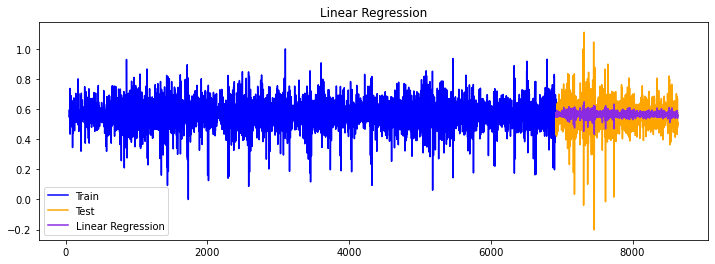

In [91]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [92]:
rw12_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["vm_memory_gb"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['vm_memory_gb'], test['baseline']))] })

In [93]:
lr_mape = mean_absolute_error(test["vm_memory_gb"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw12_results = pd.concat([rw12_results, lr_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059484,0.085185


### Decision Tree

In [94]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 8}
0.05954097638231626


In [100]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=8, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

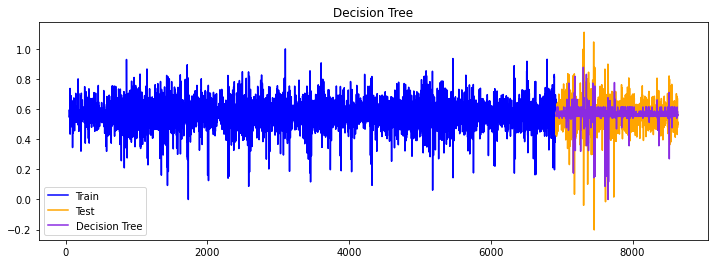

In [101]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [102]:
dt_mape = mean_absolute_error(test["vm_memory_gb"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw12_results = pd.concat([rw12_results, dt_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059484,0.085185
0,Decision Tree,0.061853,0.092024


### Random Forest

In [95]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.07888199752113878


In [103]:
rf = RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

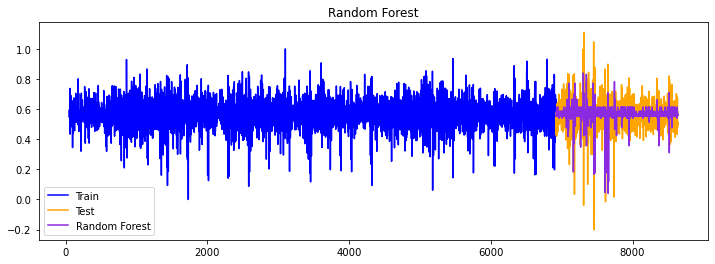

In [104]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [105]:
rf_mape = mean_absolute_error(test["vm_memory_gb"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw12_results = pd.concat([rw12_results, rf_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059484,0.085185
0,Decision Tree,0.061853,0.092024
0,Random Forest,0.061847,0.091493


### Gradient Boosting

In [96]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}
0.08084595691308072


In [20]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=100,random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

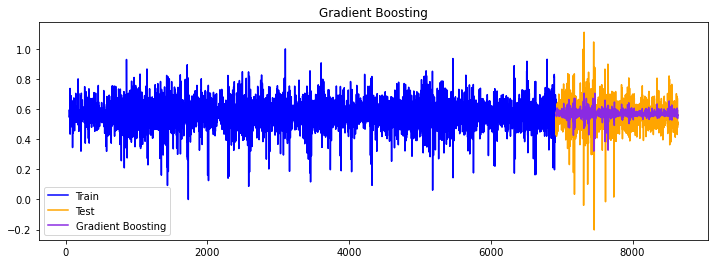

In [21]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

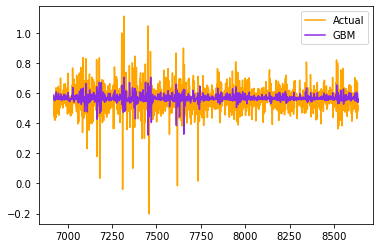

In [22]:
plt.figure(figsize=(6,4))
plt.plot(test['vm_memory_gb'], label='Actual', color="orange")
plt.plot(test['gb_pred'], label='GBM', color="blueviolet")
plt.legend(loc='best')
plt.show()

In [108]:
gb_mape = mean_absolute_error(test["vm_memory_gb"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw12_results = pd.concat([rw12_results, gb_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059484,0.085185
0,Decision Tree,0.061853,0.092024
0,Random Forest,0.061847,0.091493
0,Gradient Boosting,0.059487,0.084743


### KNN

In [97]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
0.023793318734873725


In [109]:
knn_model = KNeighborsRegressor(algorithm='auto', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

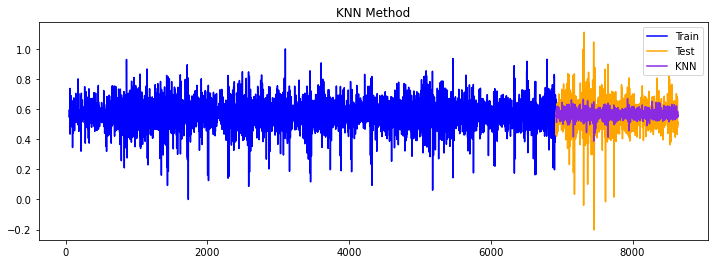

In [110]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [111]:
knn_mape = mean_absolute_error(test["vm_memory_gb"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw12_results = pd.concat([rw12_results, knn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059484,0.085185
0,Decision Tree,0.061853,0.092024
0,Random Forest,0.061847,0.091493
0,Gradient Boosting,0.059487,0.084743
0,KNN,0.060156,0.085956


### Neural Network

In [98]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.05998685081274291


In [23]:
nn_model = MLPRegressor(random_state=1, activation='relu', hidden_layer_sizes=200, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

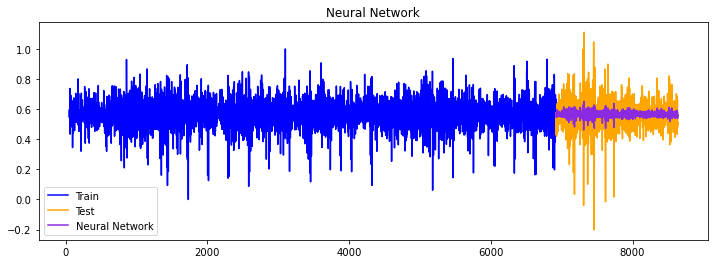

In [24]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

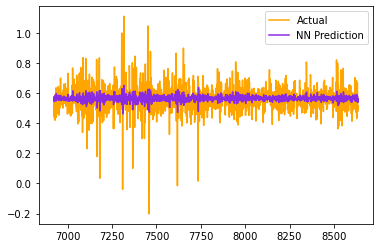

In [25]:
plt.figure(figsize=(6,4))
plt.plot(test['vm_memory_gb'], label='Actual', color="orange")
plt.plot(test['nn_pred'], label='NN Prediction', color="blueviolet")
plt.legend(loc='best')
plt.show()

In [114]:
nn_mape = mean_absolute_error(test["vm_memory_gb"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw12_results = pd.concat([rw12_results, nn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059484,0.085185
0,Decision Tree,0.061853,0.092024
0,Random Forest,0.061847,0.091493
0,Gradient Boosting,0.059487,0.084743
0,KNN,0.060156,0.085956
0,Neural Network,0.059396,0.085001


### Simple Moving Average

In [99]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:]+[0]

In [115]:
test = test.drop(test.head(1).index) # Drop last row

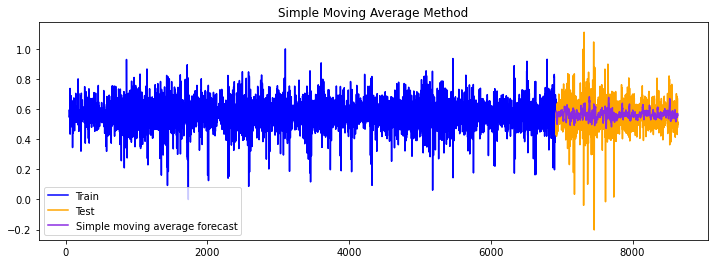

In [116]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_memory_gb'], label='Train', color="b")
plt.plot(test['vm_memory_gb'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [117]:
sma_mape = mean_absolute_error(test["vm_memory_gb"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['vm_memory_gb'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw12_results = pd.concat([rw12_results, sma_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.077920,0.110551
0,Linear Regression,0.059484,0.085185
0,Decision Tree,0.061853,0.092024
0,Random Forest,0.061847,0.091493
0,Gradient Boosting,0.059487,0.084743
0,KNN,0.060156,0.085956
0,Neural Network,0.059396,0.085001
0,Simple Moving Avg.,0.063060,0.091826


# Result Comparision

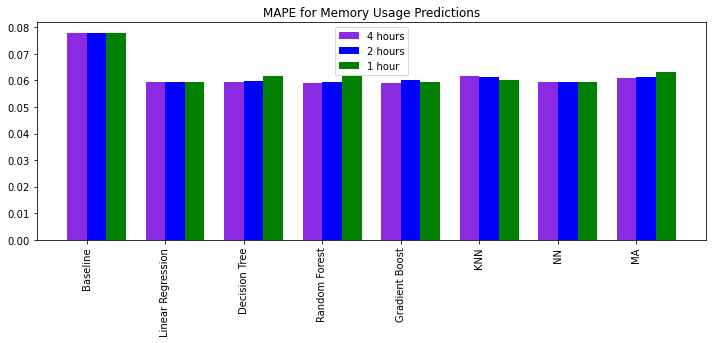

In [118]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["MAE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["MAE"], width=width, label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["MAE"], width=width, label="1 hour", color="g")
plt.legend(loc="best")
plt.title("MAPE for Memory Usage Predictions")
plt.xticks(r + width/2,['Baseline','Linear Regression','Decision Tree','Random Forest','Gradient Boost', 'KNN',"NN", 'MA'], rotation=90)
plt.show()

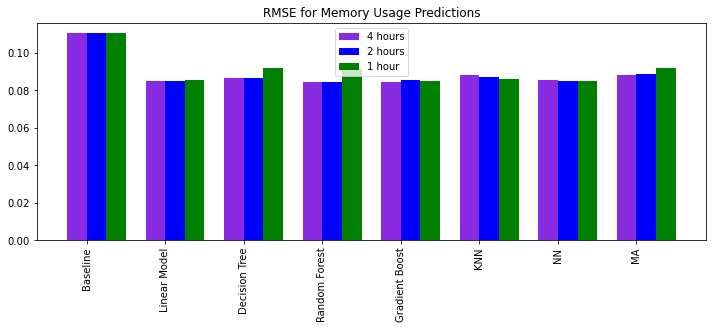

In [119]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["RMSE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["RMSE"], width=width, label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["RMSE"], width=width, label="1 hour", color="g")
plt.legend(loc="best")
plt.title("RMSE for Memory Usage Predictions")
plt.xticks(r + width/2,['Baseline', 'Linear Model','Decision Tree','Random Forest','Gradient Boost', 'KNN','NN', 'MA'], rotation=90)
plt.show()

In [120]:
rw48_results = rw48_results.reset_index()
rw24_results = rw24_results.reset_index()
rw12_results = rw12_results.reset_index()

In [121]:
total_results = pd.merge(rw48_results, rw24_results, on='Method', how='outer')
total_results = pd.merge(total_results, rw12_results, on='Method', how='outer')
total_results

,index_x,Method,MAE_x,RMSE_x,index_y,MAE_y,RMSE_y,index,MAE,RMSE
0,0,Baseline,0.077920,0.110551,0,0.077920,0.110551,0,0.077920,0.110551
1,0,Linear Regression,0.059328,0.085116,0,0.059372,0.085086,0,0.059484,0.085185
2,0,Decision Tree,0.059583,0.086302,0,0.059644,0.086634,0,0.061853,0.092024
3,0,Random Forest,0.058993,0.084309,0,0.059270,0.084498,0,0.061847,0.091493
4,0,Gradient Boosting,0.059079,0.084269,0,0.060181,0.085258,0,0.059487,0.084743
5,0,KNN,0.061859,0.088270,0,0.061483,0.086978,0,0.060156,0.085956
6,0,Neural Network,0.059602,0.085413,0,0.059513,0.085128,0,0.059396,0.085001
7,0,Simple Moving Avg.,0.060773,0.087852,0,0.061331,0.088798,0,0.063060,0.091826


In [122]:
total_results = total_results[["Method","MAE_x", "RMSE_x", "MAE_y", "RMSE_y", "MAE", "RMSE"]]

In [123]:
total_results = total_results.rename(columns={total_results.columns[0]: "Methods", 
                              total_results.columns[1]: "MAE (w=48)", total_results.columns[2]: "RMSE (w=48)", 
                              total_results.columns[3]: "MAE (w=24)", total_results.columns[4]: "RMSE (w=24)", 
                              total_results.columns[5]: "MAE (w=12)", total_results.columns[6]: "RMSE (w=12)", 
                            })

In [124]:
total_results.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Results/memory_results.csv")